### Example of expected power module usage

In [1]:
import sys
import numpy as np
import pandas as pd
import datetime as dt
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

sys.path.append(r'C:\Users\abbey\OneDrive\Documents\Projects\WindEnergy\wind-energy-analytics')
sys.path.append(r'C:\Users\abbey\OneDrive\Documents\Projects\WindEnergy\wind-energy-analytics\scada_data_analysis')

import modules
import modules.expected_power as EP
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import interp1d
from utils.binning_function import binning_func
from modules.power_curve_preprocessing import PowerCurveFiltering

### Load Data

In [2]:
train_df = pd.read_csv(r'../datasets/training_data.zip')   
test_df = pd.read_csv(r'../datasets/test_data.zip')

### Data Exploration

In [3]:
train_df.shape

(151313, 138)

In [4]:
test_df.shape

(64617, 138)

### Test Expected Power Module

In [12]:
sys.modules['modules.expected_power']

<module 'modules.expected_power' from 'C:\\Users\\abbey\\OneDrive\\Documents\\Projects\\WindEnergy\\wind-energy-analytics\\scada_data_analysis\\modules\\expected_power.py'>

In [26]:
# del sys.modules['modules.expected_power'] 
importlib.reload(modules.expected_power)
import modules.expected_power
power_model = modules.expected_power.ExpectedPower(turbine_label='Wind_turbine_name', windspeed_label='Ws_avg', power_label='P_avg', method='binning', kind='cubic')

In [27]:
%%time
power_model.fit(train_df)

CPU times: total: 4.7 s
Wall time: 4.7 s


In [28]:
%%time
pred_df = power_model.predict(test_df)

CPU times: total: 109 ms
Wall time: 101 ms


In [29]:
pred_temp = pred_df[pred_df['Wind_turbine_name'] == 'R80721']

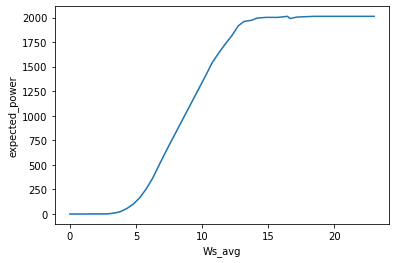

In [30]:
#linear
sns.lineplot(x=pred_temp['Ws_avg'], y=pred_temp['expected_power']);

<AxesSubplot:xlabel='Ws_avg', ylabel='expected_power'>

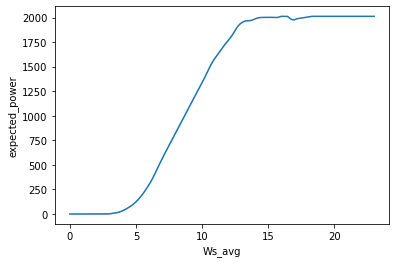

In [11]:
#quadratic
sns.lineplot(x=pred_temp['Ws_avg'], y=pred_temp['expected_power']);

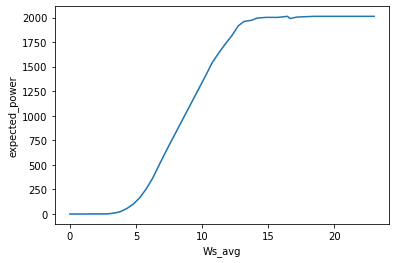

In [22]:
#cubic
sns.lineplot(x=pred_temp['Ws_avg'], y=pred_temp['expected_power']);

In [10]:
y_exp = pred_df['expected_power']
y_true = pred_df['P_avg']

In [11]:
x = range(len(y_exp))

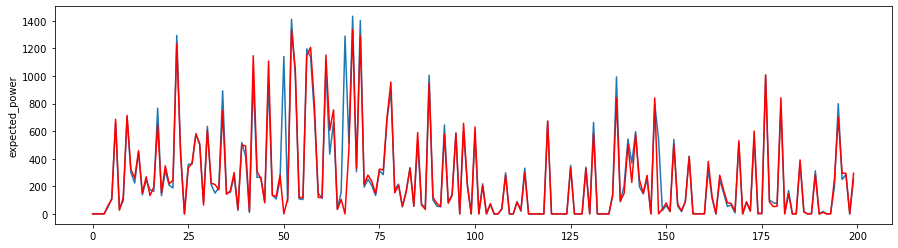

In [12]:
#linear
plt.figure(figsize=(15,4))
sns.lineplot(x=x[:200],y=y_exp[:200]);
sns.lineplot(x=x[:200],y=y_true[:200], color='red');

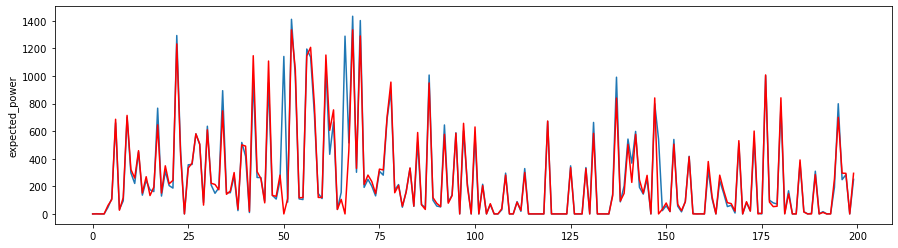

In [14]:
#quadratic
plt.figure(figsize=(15,4))
sns.lineplot(x=x[:200],y=y_exp[:200]);
sns.lineplot(x=x[:200],y=y_true[:200], color='red');

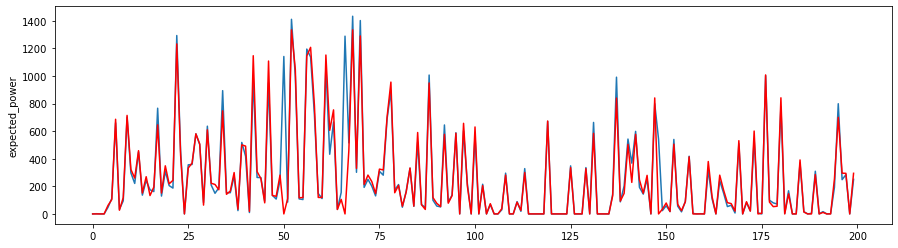

In [12]:
#cubic
plt.figure(figsize=(15,4))
sns.lineplot(x=x[:200],y=y_exp[:200]);
sns.lineplot(x=x[:200],y=y_true[:200], color='red');

##### Mean absolute error metric

In [13]:
# linear
mean_absolute_error(pred_df.P_avg.values, pred_df.expected_power.values)

45.17562636015988

In [16]:
# quad
mean_absolute_error(pred_df.P_avg.values, pred_df.expected_power.values)

45.45796272651877

In [13]:
#cubic
mean_absolute_error(pred_df.P_avg.values, pred_df.expected_power.values)

45.417641046316625

##### Root mean square metric

In [14]:
#linear
mean_squared_error(pred_df.P_avg.values, pred_df.expected_power.values, squared=False)

118.90860429129623

In [17]:
#quad
mean_squared_error(pred_df.P_avg.values, pred_df.expected_power.values, squared=False)

119.09526974356719

In [14]:
#cubic
mean_squared_error(pred_df.P_avg.values, pred_df.expected_power.values, squared=False)

118.30471372409444